<a href="https://colab.research.google.com/github/narendra7959/Deep-Learning-Practicals/blob/main/24040208002_MDSC_302(P)_AV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [3]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:
# Transform with data augmentation to prevent overfitting
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [6]:

# Select two classes (cat=3, dog=5)
class1, class2 = 3, 5
train_idx = np.where((np.array(train_data.targets) == class1) | (np.array(train_data.targets) == class2))[0]
test_idx = np.where((np.array(test_data.targets) == class1) | (np.array(test_data.targets) == class2))[0]

train_data.targets = np.array(train_data.targets)
test_data.targets = np.array(test_data.targets)

train_subset = Subset(train_data, train_idx)
test_subset = Subset(test_data, test_idx)

In [7]:

# Relabel classes to 0 (cat) and 1 (dog)
train_data.targets[train_idx] = (train_data.targets[train_idx] == class2).astype(int)
test_data.targets[test_idx] = (test_data.targets[test_idx] == class2).astype(int)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

Training dataset size: 10000
Validation dataset size: 2000
Classes: ['cat', 'dog']
Sample tensor shape: torch.Size([3, 32, 32])


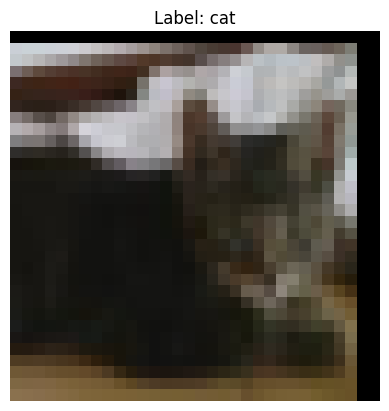

In [8]:
# Dataset inspection (aligning with notebook)
print("Training dataset size:", len(train_subset))
print("Validation dataset size:", len(test_subset))
print("Classes:", ['cat', 'dog'])
img, label = train_subset[0]
print("Sample tensor shape:", img.shape)
plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize for display
plt.title(f"Label: {['cat', 'dog'][label]}")
plt.axis("off")
plt.show()

In [9]:
# Define the CNN Model (your architecture)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.dropout = nn.Dropout(0.2)  # Added to prevent overfitting
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(F.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(F.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = F.tanh(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [10]:
# Count model parameters (section 7.2.9)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Model params:", count_parameters(model))

Model params: 18090


In [11]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [12]:


# Training loop with train & validation metrics
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training step
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = 100 * correct_val / total_val

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/10] | Train Loss: 0.6690, Train Acc: 58.89% | Val Loss: 0.6461, Val Acc: 62.05%
Epoch [2/10] | Train Loss: 0.6417, Train Acc: 62.98% | Val Loss: 0.6224, Val Acc: 65.05%
Epoch [3/10] | Train Loss: 0.6231, Train Acc: 64.86% | Val Loss: 0.6066, Val Acc: 67.15%
Epoch [4/10] | Train Loss: 0.6072, Train Acc: 66.90% | Val Loss: 0.5871, Val Acc: 68.05%
Epoch [5/10] | Train Loss: 0.5976, Train Acc: 67.84% | Val Loss: 0.5764, Val Acc: 68.60%
Epoch [6/10] | Train Loss: 0.5867, Train Acc: 68.75% | Val Loss: 0.5796, Val Acc: 69.75%
Epoch [7/10] | Train Loss: 0.5819, Train Acc: 69.04% | Val Loss: 0.5886, Val Acc: 68.85%
Epoch [8/10] | Train Loss: 0.5782, Train Acc: 68.90% | Val Loss: 0.5815, Val Acc: 69.15%
Epoch [9/10] | Train Loss: 0.5789, Train Acc: 69.29% | Val Loss: 0.5811, Val Acc: 68.65%
Epoch [10/10] | Train Loss: 0.5778, Train Acc: 69.68% | Val Loss: 0.5586, Val Acc: 70.25%


In [13]:
# Final evaluation
print(f"\nFinal Test Accuracy: {val_acc:.2f}%")


Final Test Accuracy: 70.25%



Predicted: ['cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog']


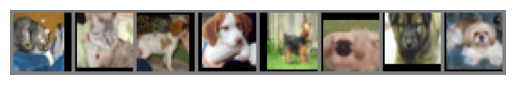

In [14]:
# Visualize some predictions
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8]))
print("\nPredicted:", ['dog' if p == 1 else 'cat' for p in predicted[:8].cpu().numpy()])
plt.show()